# Complex Data Analysis Project
### Group 7
* Tommaso Tragno - fc64699
* Antonio Alampi - fc64316
* Meike Veen - fc64408

# stocazzo

In [1]:
# netowrks
import networkx as nx
import igraph as ig

# data processing
import pandas as pd
import numpy as np

#some functions to make our lifes easier
import sys
sys.path.append("../")
from common_functions import *

# viz
#import pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns

# gzip
import gzip

### Graph creation

In [2]:
# Path to file
file_path = 'soc-Epinions1.txt.gz'

# Initialize a directed graph
G = nx.DiGraph()

# Load the edge list into the directed graph
with gzip.open(file_path, 'rt') as f:
    # Skip header lines that start with '#'
    edges = [line.strip().split('\t') for line in f if not line.startswith('#')]
    # Add edges to the graph
    G.add_edges_from((int(src), int(dst)) for src, dst in edges)

# Basic graph statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
is_directed = G.is_directed()

# Print basic graph statistics
print("Total Nodes:", num_nodes)
print("Total Edges:", num_edges)
print("Is Directed:", is_directed)

Total Nodes: 75879
Total Edges: 508837
Is Directed: True


### Degree analysis

In [3]:
def compute_degree(graph):
    # Compute in-degree and out-degree for each node
    degree_data = {
        "Node": [],
        "In-Degree": [],
        "Out-Degree": []
    }

    for node in graph.nodes:
        in_degree = graph.in_degree(node)
        out_degree = graph.out_degree(node)
        degree_data["Node"].append(node)
        degree_data["In-Degree"].append(in_degree)
        degree_data["Out-Degree"].append(out_degree)
    
    return degree_data

In [4]:
degree_data = compute_degree(G)

In [5]:
# Calculate the average in-degree and out-degree
total_in_degree = sum(degree_data["In-Degree"])
total_out_degree = sum(degree_data["Out-Degree"])
num_nodes = G.number_of_nodes()

average_in_degree = total_in_degree / num_nodes
average_out_degree = total_out_degree / num_nodes

# Display the average degree
print(f"Average in-degree: {average_in_degree}")
print(f"Average out-degree: {average_out_degree}")

Average in-degree: 6.7059001831863885
Average out-degree: 6.7059001831863885


In [6]:
# Convert results to a pandas DataFrame for easier analysis and viewing
degree_df = pd.DataFrame(degree_data)
degree_df.head()  # Display the first few rows

# Save the DataFrame to a CSV file
degree_df.to_csv('node_degrees.csv', index=False)

### Hub finding:
* most trusted nodes
* more truster nodes
* both trusted and truster

In [7]:
node_data = list(zip(degree_data["Node"], degree_data["In-Degree"], degree_data["Out-Degree"]))

# Sort by In-Degree in descending order and take the top 5
top_in_degree = sorted(node_data, key=lambda x: x[1], reverse=True)[:5]

# Sort by Out-Degree in descending order and take the top 5
top_out_degree = sorted(node_data, key=lambda x: x[2], reverse=True)[:5]

# Display results
print("Top 5 nodes by In-Degree:", top_in_degree)
print("Top 5 nodes by Out-Degree:", top_out_degree)

threshold = 600
top_in_out_degree = []
for i in range(len(degree_data["Node"])):
    in_degree = degree_data["In-Degree"][i]
    out_degree = degree_data["Out-Degree"][i]
    if in_degree > threshold and out_degree > threshold:
        top_in_out_degree.append(degree_data["Node"][i])

# Output the result
print(f'There are {len(top_in_out_degree)} nodes with both In-Degree and Out-Degree above the threshold: {top_in_out_degree}')
print(f'The in degree is {G.in_degree(top_in_out_degree)} and the out degree is {G.out_degree(top_in_out_degree)}')

Top 5 nodes by In-Degree: [(18, 3035, 44), (143, 1521, 171), (737, 1317, 372), (790, 1284, 102), (136, 1180, 111)]
Top 5 nodes by Out-Degree: [(645, 408, 1801), (763, 293, 1669), (634, 378, 1621), (71399, 116, 1128), (3924, 92, 976)]
There are 1 nodes with both In-Degree and Out-Degree above the threshold: [44]
The in degree is [(44, 672)] and the out degree is [(44, 843)]


### Hub analysis

In [8]:
# Define the two hub nodes
node_a = 18
node_b = 143

# Check if the hubs are connected
if G.has_edge(node_a, node_b):
    print(f'The hubs {node_a} and {node_b} are directly connected.')
else:
    print(f'The hubs {node_a} and {node_b} are not directly connected.')
    
    # If not directly connected, find the shortest path (if it exists)
    try:
        path = nx.shortest_path(G, node_a, node_b)
        print(f'The shortest path between {node_a} and {node_b} is: {path}')
    except nx.NetworkXNoPath:
        print(f'There is no path between {node_a} and {node_b}.')

# Get the predecessors of the target nodes
predecessors_a = set(G.predecessors(node_a))
predecessors_b = set(G.predecessors(node_b))

# Find nodes that have outgoing edges to both target nodes
common_predecessors = predecessors_a & predecessors_b

# Output the result
print(f'There are {len(common_predecessors)} nodes with outgoing edges to both {node_a} and {node_b}: {common_predecessors}')

The hubs 18 and 143 are not directly connected.
The shortest path between 18 and 143 is: [18, 128, 143]
There are 588 nodes with outgoing edges to both 18 and 143: {4100, 2055, 2057, 4110, 6159, 16, 10259, 2069, 27, 31, 16416, 33, 36, 2084, 39, 2088, 2097, 2103, 58, 62, 65, 67, 4165, 4167, 6215, 77, 79, 82, 83, 85, 4182, 10330, 91, 4187, 4188, 8288, 2144, 10338, 99, 12388, 4197, 14438, 4199, 2152, 4200, 4202, 107, 2157, 112, 18544, 119, 2167, 71801, 8316, 124, 126, 128, 8321, 10378, 140, 141, 2189, 6285, 145, 146, 8344, 2201, 172, 10413, 2226, 37043, 2231, 2232, 18620, 198, 4295, 12496, 212, 215, 217, 4313, 2270, 223, 225, 2277, 6374, 8423, 232, 2279, 30953, 6378, 4333, 4334, 239, 2287, 6382, 8434, 6383, 6393, 6397, 6402, 2308, 14600, 4368, 6419, 2329, 290, 291, 4394, 8491, 24877, 8495, 4406, 318, 320, 2369, 4418, 329, 340, 342, 343, 6487, 348, 8541, 356, 2410, 375, 379, 45439, 384, 385, 57728, 2433, 4482, 6527, 8592, 6555, 418, 8613, 2470, 2471, 431, 4527, 4537, 443, 445, 447, 14783, 

In [ ]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
print("Top 5 nodes by degree centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

# Betweenness centrality (for larger graphs, consider approximations)
betweenness_centrality = nx.betweenness_centrality(G, k=100, seed=42)  # Using sample for speed
print("Top 5 nodes by betweenness centrality:", sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

## Core network

In [10]:
def get_core_nodes(graph, threshold):
    """
    Recursively removes nodes with in-degree + out-degree < threshold and returns the core graph.
    
    Parameters:
    - graph: A NetworkX DiGraph (directed graph)
    
    Returns:
    - A NetworkX DiGraph representing the core of the network
    """
    # Create a copy of the graph to avoid modifying the original
    core_graph = graph.copy()
    
    count = 0
    number_of_removed = 0
    while True:
        # Identify nodes with in-degree + out-degree < threshold
        nodes_to_remove = [
            node for node in core_graph.nodes 
            if core_graph.in_degree(node) + core_graph.out_degree(node) < threshold
        ]
        
        # Exit condition - if no nodes meet the condition, stop the process
        if not nodes_to_remove:
            break
        
        # Remove the identified nodes
        core_graph.remove_nodes_from(nodes_to_remove)
        number_of_removed += len(nodes_to_remove)
        print(f'Iteration {count}: removed {len(nodes_to_remove)} nodes')
        count += 1
    print(f'Executed {count} iterations, removed {number_of_removed} nodes')
    return core_graph

In [11]:
# Get the core graph
threshold = 8
core_G = get_core_nodes(G, threshold)

# Print the number of nodes and edges in the original and core graphs
print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Core Graph: {core_G.number_of_nodes()} nodes, {core_G.number_of_edges()} edges")

Iteration 0: removed 59804 nodes
Iteration 1: removed 2508 nodes
Iteration 2: removed 324 nodes
Iteration 3: removed 65 nodes
Iteration 4: removed 13 nodes
Iteration 5: removed 3 nodes
Iteration 6: removed 1 nodes
Executed 7 iterations, removed 62718 nodes
Original Graph: 75879 nodes, 508837 edges
Core Graph: 13161 nodes, 381022 edges


In [12]:
core_degree_data = compute_degree(core_G)

core_node_data = list(zip(core_degree_data["Node"], core_degree_data["In-Degree"], core_degree_data["Out-Degree"]))

# Sort by In-Degree in descending order and take the top 5
core_top_in_degree = sorted(core_node_data, key=lambda x: x[1], reverse=True)[:5]

# Sort by Out-Degree in descending order and take the top 5
core_top_out_degree = sorted(core_node_data, key=lambda x: x[2], reverse=True)[:5]

# Display results
print("Top 5 nodes by In-Degree:", core_top_in_degree)
print("Top 5 nodes by Out-Degree:", core_top_out_degree)

Top 5 nodes by In-Degree: [(18, 2449, 44), (143, 1288, 140), (737, 1098, 365), (790, 1079, 102), (1179, 1049, 85)]
Top 5 nodes by Out-Degree: [(645, 361, 1518), (634, 307, 1181), (763, 177, 836), (71399, 93, 835), (3924, 86, 793)]


## Random network

In [17]:
# Extract the largest Weakly Connected Component (WCC)
# For a directed graph, weakly connected components treat edges as undirected for connectivity purposes
largest_wcc = max(nx.weakly_connected_components(G), key=len)

# Create a subgraph of the largest WCC
G_wcc = G.subgraph(largest_wcc).copy()

# Statistics for the largest WCC
wcc_num_nodes = G_wcc.number_of_nodes()
wcc_num_edges = G_wcc.number_of_edges()

# Print WCC statistics
print("Nodes in largest WCC:", wcc_num_nodes)
print("Edges in largest WCC:", wcc_num_edges)

Nodes in largest WCC: 75877
Edges in largest WCC: 508836


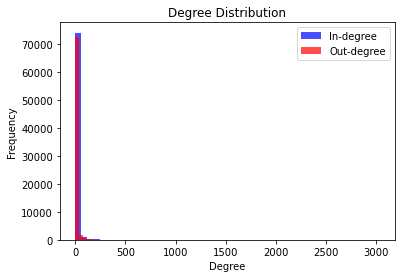

In [18]:
# Compute in-degree and out-degree distributions
in_degrees = [G_wcc.in_degree(n) for n in G_wcc.nodes()]
out_degrees = [G_wcc.out_degree(n) for n in G_wcc.nodes()]

# Plot in-degree distribution
plt.hist(in_degrees, bins=50, color='blue', alpha=0.7, label='In-degree')
plt.hist(out_degrees, bins=50, color='red', alpha=0.7, label='Out-degree')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.title("Degree Distribution")
plt.show()

In [19]:
# Calculate the average clustering coefficient
avg_clustering = nx.average_clustering(G_wcc.to_undirected())  # Convert to undirected for clustering
print("Average Clustering Coefficient:", avg_clustering)

Average Clustering Coefficient: 0.1377600044367361


In [ ]:
# Calculate the average shortest path length
# This can be computationally intensive; only use on smaller graphs or expect it to take time
try:
    avg_shortest_path_length = nx.average_shortest_path_length(G_wcc)
    print("Average Shortest Path Length:", avg_shortest_path_length)
except Exception as e:
    print("Error calculating shortest path length:", e)

In [ ]:
# Calculate assortativity coefficient
assortativity = nx.degree_assortativity_coefficient(G_wcc)
print("Assortativity Coefficient:", assortativity)

In [ ]:
nx.draw_networkx(G, node_size=1000, node_color='lightblue', with_labels=True, font_size=8)